<a href="https://colab.research.google.com/github/Nburkhal/DS-Unit-2-Regression-Classification/blob/master/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do exploratory visualizations with Seaborn.
- [x] Do one-hot encoding of categorical features.
- [x] Do feature selection with `SelectKBest`.
- [x] Fit a linear regression model with multiple features.
- [x] Get mean absolute error for the test set.
- [x] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [x] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 5.6MB/s 
     |████████████████████████████████| 133kB 16.4MB/s 
     |████████████████████████████████| 7.1MB 42.2MB/s 
     |████████████████████████████████| 614kB 41.4MB/s 
     |████████████████████████████████| 225kB 42.7MB/s 
     |████████████████████████████████| 768kB 15.8MB/s 
     |████████████████████████████████| 194kB 43.5MB/s 
     |████████████████████████████████| 51kB 18.3MB/s 
     |████████████████████████████████| 51kB 18.7MB/s 
     |████████████████████████████████| 737kB 38.5MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=0a852738d93553b47a309c31a1d66564e6196720a34b9d9f8964e8047a0f00bc
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=d81572ce10aae950efb91074f01c04b68ab4f2d49269b2f020b7b55b4145716c
  Stored

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
# Check out what the dataframe looks like
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [5]:
# Select subset of data
# BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
mask = df['BUILDING_CLASS_CATEGORY'].str.contains('01 ONE FAMILY DWELLINGS')
df = df[mask]
df.shape

(5061, 21)

In [9]:
# SALE_PRICE > 100000 & SALE_PRICE < 2000000
price_mask = (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)
df = df[price_mask]
df.shape

(3151, 21)

In [10]:
#Convert SALE_DATE to datetime for train/test split purposes
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3151
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [18]:
# Check for null values
df.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3151
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3150
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
dtype: int64

In [19]:
# Drop EASE-MENT and APARTMENT_NUMBER columns
# They contain no data
df = df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER'], axis=1)
print(df.shape)
df.columns

(3151, 19)


Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [20]:
# Split the data
# Train data = Jan-Mar
# Test data = Apr

train = df[df['SALE_DATE'].dt.month < 4]
test = df[df['SALE_DATE'].dt.month == 4]
train.shape, test.shape

((2507, 19), (644, 19))

In [21]:
# Exploratory visualization with seaborn

# Look at relationship between borough and price (seems interesting)
px.scatter(train, x='BOROUGH', y='SALE_PRICE', trendline='ols')

In [22]:
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    739000.000000
2    473104.623967
3    768734.633166
4    649005.172757
5    537305.802115
Name: SALE_PRICE, dtype: float64

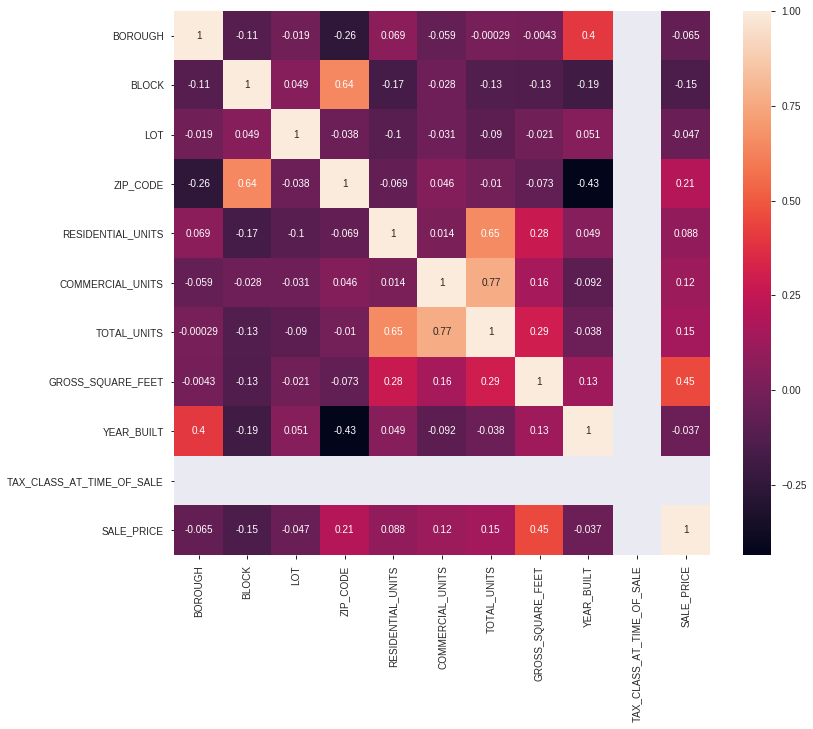

In [23]:
# Are there any strong correlations amongst the variables?
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True);

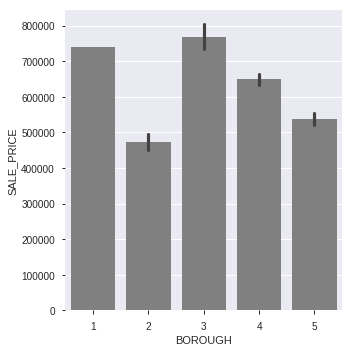

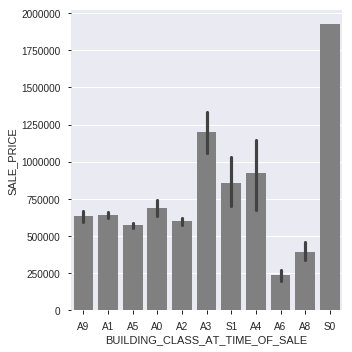

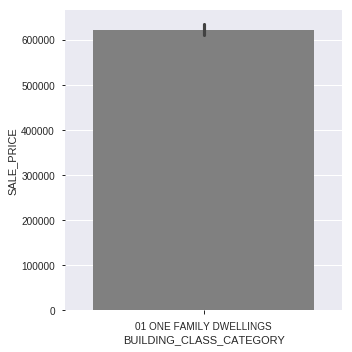

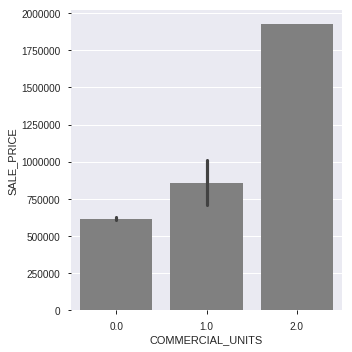

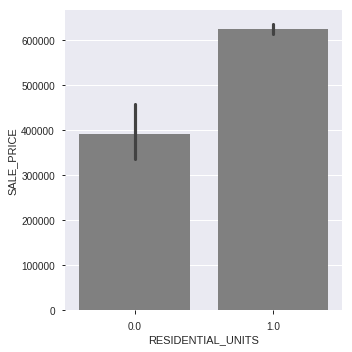

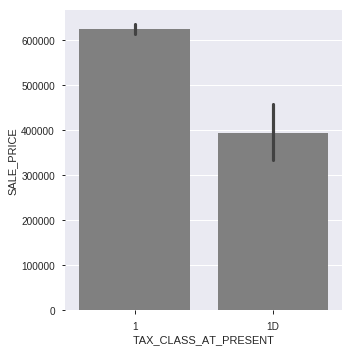

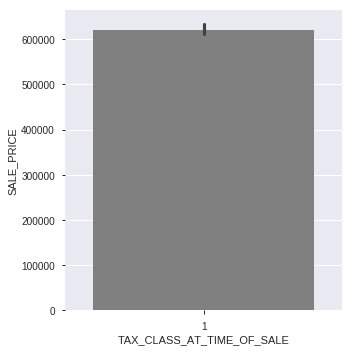

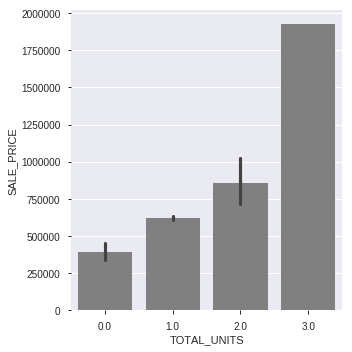

In [24]:
for col in sorted(train.columns):
  
  if train[col].nunique() < 12:
    
    sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
    plt.show();

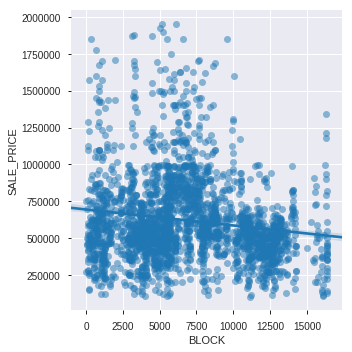

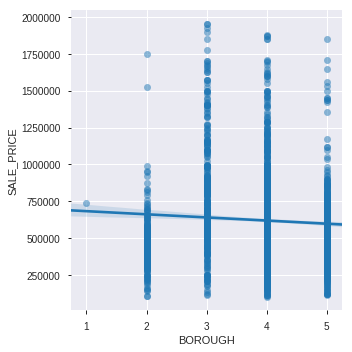

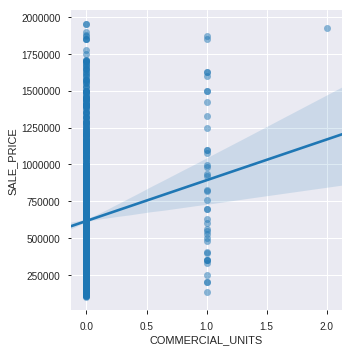

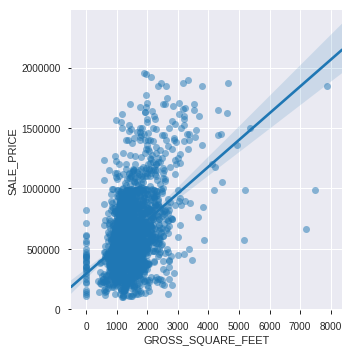

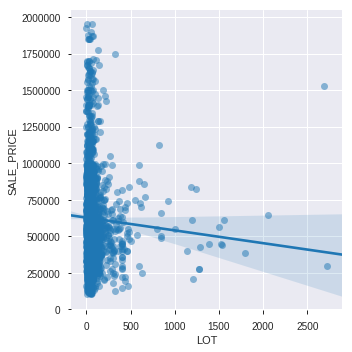

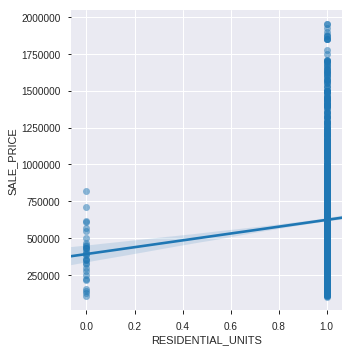

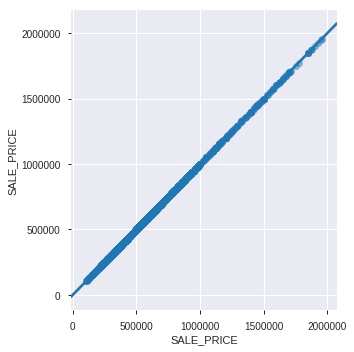

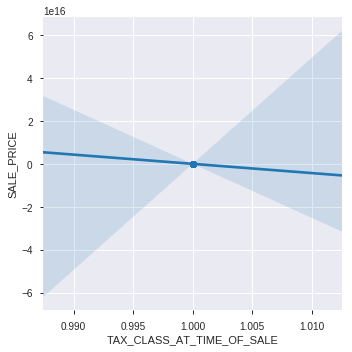

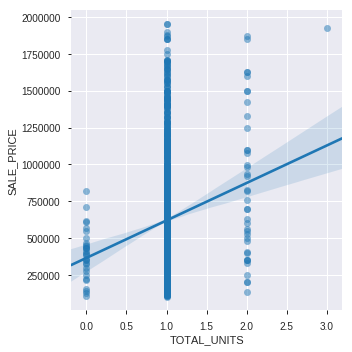

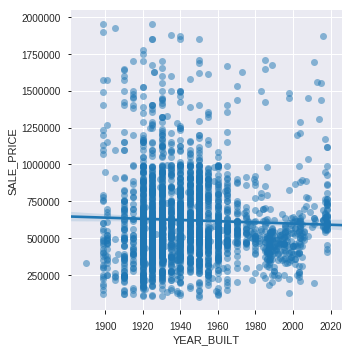

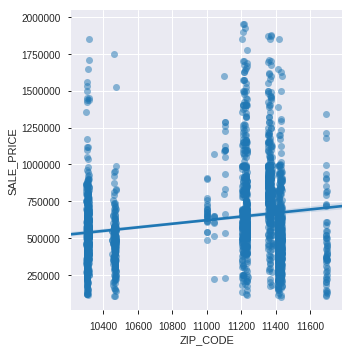

In [25]:
numeric = train.select_dtypes('number')

for col in sorted(numeric.columns):
  
  sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.5))
  plt.show()

In [27]:
# One-hot encoding of categorical features

# Check the unique values of each non-numeric column in our train set
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2507,176,FLUSHING-NORTH,77,NaN,NaN
LAND_SQUARE_FEET,2507,887,"4,000",234,NaN,NaN
ADDRESS,2507,2497,294 FREEBORN STREET,2,NaN,NaN


In [28]:
# Explore TAX_CLASS_AT_PRESENT feature
train['TAX_CLASS_AT_PRESENT'].value_counts(normalize=True)

1     0.987635
1D    0.012365
Name: TAX_CLASS_AT_PRESENT, dtype: float64

In [29]:
# Explore BUILDING_CLASS_AT_TIME_OF_SALE feature
train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts(normalize=True)

A1    0.366574
A5    0.310730
A2    0.164739
A9    0.076984
A0    0.026725
S1    0.015556
A3    0.015158
A8    0.012365
A6    0.005584
A4    0.005185
S0    0.000399
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: float64

In [32]:
# BOROUGH isn't included in the non-numeric features, but is definitely categorical

train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

train.describe(exclude='number').T.sort_values(by='unique')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BOROUGH,2507,5,4,1204,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2507,176,FLUSHING-NORTH,77,NaN,NaN
LAND_SQUARE_FEET,2507,887,"4,000",234,NaN,NaN
ADDRESS,2507,2497,294 FREEBORN STREET,2,NaN,NaN


In [33]:
# Reduce cardinality of NEIGHBORHOOD feature

top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [34]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BOROUGH,2507,5,4,1204,NaN,NaN
NEIGHBORHOOD,2507,11,OTHER,1908,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
LAND_SQUARE_FEET,2507,887,"4,000",234,NaN,NaN
ADDRESS,2507,2497,294 FREEBORN STREET,2,NaN,NaN


In [40]:
# Drop BUILDING_CLASS_CATEGORY from train & test sets (no real value)

train = train.drop(columns='BUILDING_CLASS_CATEGORY', axis=1)
test = test.drop(columns='BUILDING_CLASS_CATEGORY', axis=1)

train.shape, test.shape

((2507, 18), (644, 18))

In [0]:
# One-hot encode the categorical data

target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE', 'LAND_SQUARE_FEET', 'ADDRESS']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)

# One-hot encoded
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Apply scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [47]:
# Figure out how many features to use - what gives the best score?

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features')
  
  # Create selector to find KBest features
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train_scaled, y_train)
  X_test_selected = selector.transform(X_test_scaled)
  
  # Create linear regression model
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  
  # Predict y for X test data
  y_pred = model.predict(X_test_selected)


  # Calculate metrics on the test data
  test_error = mean_absolute_error(y_test, y_pred)
  test_r2 = r2_score(y_test, y_pred)
  test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  
  # Display metrics
  print('------------------Linear Regression Model Results------------------')
  print('Test Data')
  print('Test MAE: $', test_error)
  print('Test R^2:', test_r2)
  print('Test RMSE:', test_rmse, '\n')
  

1 features
------------------Linear Regression Model Results------------------
Test Data
Test MAE: $ 183640.5858012459
Test R^2: 0.21506982154862042
Test RMSE: 262908.8478917925 

2 features
------------------Linear Regression Model Results------------------
Test Data
Test MAE: $ 182569.26269991108
Test R^2: 0.22325870950978643
Test RMSE: 261533.8365683233 

3 features
------------------Linear Regression Model Results------------------
Test Data
Test MAE: $ 182617.86716448603
Test R^2: 0.22296700135296477
Test RMSE: 261582.94197368447 

4 features
------------------Linear Regression Model Results------------------
Test Data
Test MAE: $ 183440.74951822695
Test R^2: 0.25635987845951536
Test RMSE: 255900.47686653695 

5 features
------------------Linear Regression Model Results------------------
Test Data
Test MAE: $ 187180.8658396242
Test R^2: 0.2461721159571254
Test RMSE: 257647.4138515393 

6 features
------------------Linear Regression Model Results------------------
Test Data
Test MA

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/p

In [53]:
# Which features were used?
k = 10
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_FLUSHING-NORTH
BLOCK
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3

Features not selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_QUEENS VILLAGE
NEIGHBORHOOD_BAYSIDE
NEIGHBORHOOD_LAURELTON
NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK
NEIGHBORHOOD_SPRINGFIELD GARDENS
NEIGHBORHOOD_GREAT KILLS
NEIGHBORHOOD_SOUTH OZONE PARK
NEIGHBORHOOD_MIDLAND BEACH
NEIGHBORHOOD_ST. ALBANS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



In [0]:
# Use sklearn pipeline to do the same thing as above
# KBest k=10
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

kbest_lr = make_pipeline(SelectKBest(score_func=f_regression, k=10),
                        LinearRegression())